# Spatial KDE to Area of Prediction

This notebook integrates the outputs from notebook 01 and 02. In it, the Spatial KDE raster data for each block and economic activity is integrated to the Area of prediction generated through the morphology analysis generated for each block using Google buildings.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
# import odc
import rasterio as ro

from shapely.geometry import Point, Polygon

import seaborn as sns
import matplotlib.pyplot as plt

# from typing import Optional
from spatial_kde import spatial_kernel_density

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Data download/read and preprocessing

### Area of analysis

In [2]:
aoa_gdf = gpd.read_file("../../data/processed/prediccion_uso_suelo/Distrito_Zona5.geojson")
aoa_gdf = aoa_gdf.to_crs("EPSG:6372")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 4)


,id,area,perimeter,geometry
0,0,3.456908e+07,22034.335455,"POLYGON ((2350492.442 961359.575, 2350476.14 9..."


### Spatial KDE directory

In [3]:
kde_dir = '../../data/processed/prediccion_uso_suelo/test/kde_output/'

### Area of prediction

In [4]:
aop_gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/test/area_of_prediction_uso_suelo.gpkg')
aop_gdf = aop_gdf.to_crs("EPSG:6372")
print(aop_gdf.shape)
aop_gdf.head(2)

(37061, 10)


,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,geometry
0,Servicio,2257.817773,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,2747.599834,0.009869,0.063231,"MULTIPOLYGON (((2349620.239 965525.905, 234961..."
1,Sin dato,711.098560,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,900.765482,0.003235,0.090803,"MULTIPOLYGON (((2349506.214 965639.352, 234950..."


In [5]:
if 'fid' not in list(aop_gdf.columns):
    aop_gdf = aop_gdf.reset_index().rename(columns={'index':'fid'})

### Census data

In [6]:
poly_wkt = aoa_gdf.to_crs("EPSG:4326").dissolve().geometry.to_wkt()[0]

In [7]:
schema = "sociodemografico"
table = "censo_inegi_20_mza"

# Consulta que devuelve WKT en lugar de geometría nativa
query_censo = f"""
SELECT 
"cvegeo_mza",
"pobtot","geometry" FROM {schema}.{table}
WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')
"""

block_gdf = aup.gdf_from_query(query_censo)

print(block_gdf.shape)
block_gdf.head(2)

(1821, 3)


,cvegeo_mza,pobtot,geometry
0,1412000011225001,0,"POLYGON ((-103.43256 20.67151, -103.43314 20.6..."
1,1412000011225002,103,"POLYGON ((-103.4316 20.67233, -103.43152 20.67..."


## Data to Area of prediction

Population data

In [8]:
aop_data = aop_gdf.merge(block_gdf[['cvegeo_mza','pobtot']], left_on='CVEGEO',
                        right_on='cvegeo_mza')
aop_data = aop_data.drop(columns=['cvegeo_mza'])
print(aop_data.shape)
aop_data.head(2)

(37061, 12)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,geometry,pobtot
0,0,Servicio,2257.817773,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,2747.599834,0.009869,0.063231,"MULTIPOLYGON (((2349620.239 965525.905, 234961...",0
1,1,Sin dato,711.098560,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,900.765482,0.003235,0.090803,"MULTIPOLYGON (((2349506.214 965639.352, 234950...",0


**WARNING** Parallel processing

Test

In [9]:
cvegeo_mza = '1412000011282017'
kde_block = f'kde_mnz_{cvegeo_mza}'
aop_tmp = aop_gdf.loc[aop_gdf.CVEGEO==cvegeo_mza].copy()

# iterate over every file
for filename in os.listdir(kde_dir):

    # gather those corresponding to the specific block
    if filename.startswith(kde_block):

        # skip complementary raster files
        if filename.endswith('.aux.xml'):
            continue

        kde_act = filename.replace(kde_block+'_',"").replace('.tif',"").lower()

        # read file
        raster_kde = ro.open(kde_dir+filename)

        aop_tmp[kde_act] = aop_tmp.geometry.apply(
            lambda geom: aup.clean_mask(geom, raster_kde)).apply(np.ma.mean)
aop_tmp.head(4)

,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,geometry,otros,servicios,alojamiento
5684,5684,Habitacional,288.073217,75GRMH5P+P6MF,1412000011282017,51.0951,8533.619833,336.164313,0.039393,0.151994,"MULTIPOLYGON (((2353233.286 962081.345, 235323...",0.000000,0.000000,0.000000
5685,5685,Comercio,141.197421,75GRMH5P+H868,1412000011282017,7.2776,8533.619833,364.692065,0.042736,0.019955,"MULTIPOLYGON (((2353247.079 962045.916, 235324...",0.000000,2.152839,10.115772
5686,5686,Habitacional,1008.220300,75GRMH5P+X5W2,1412000011282017,66.2258,8533.619833,1166.290857,0.136670,0.056783,"MULTIPOLYGON (((2353216.222 962164.467, 235321...",7.158584,0.000000,0.000000
5687,5687,Habitacional,73.577013,75GRMH5P+R726,1412000011282017,32.9753,8533.619833,73.577013,0.008622,0.448174,"MULTIPOLYGON (((2353239.555 962110.314, 235323...",0.000000,0.000000,0.000000


In [10]:
from joblib import Parallel, delayed
from tqdm import tqdm

In [11]:
parallel_processing = True

In [12]:
def kde_to_area_of_prediction(cvegeo, aop_gdf, kde_dir):
    """Process to transfer data from kde raster to area of prediction tesselations by block"""
    kde_block = f'kde_mnz_{cvegeo}'
    aop_tmp = aop_gdf.loc[aop_gdf.CVEGEO==cvegeo].copy()

    # iterate over every file
    for filename in os.listdir(kde_dir):

        # gather those corresponding to the specific block
        if filename.startswith(kde_block):

            # skip complementary raster files
            if filename.endswith('.aux.xml'):
                continue

            kde_act = filename.replace(kde_block+'_',"").replace('.tif',"").lower()

            # read file
            raster_kde = ro.open(kde_dir+filename)

            aop_tmp[kde_act] = aop_tmp.geometry.apply(
                lambda geom: aup.clean_mask(geom, raster_kde)).apply(np.ma.mean)
    return aop_tmp

In [13]:
if parallel_processing:
    # Execute in parallel

    # Get unique CVEGEOs to process
    unique_cvegeos = aop_gdf.CVEGEO.unique()
    
    # Execute in parallel - FIXED: Remove extra brackets and pass correct parameters
    results = Parallel(n_jobs=28, verbose=1)(
        delayed(kde_to_area_of_prediction)(cvegeo, aop_gdf, kde_dir)
        for cvegeo in tqdm(unique_cvegeos, desc="Processing blocks")
    )

    # Filter out None results and concatenate all DataFrames
    valid_results = [result for result in results if result is not None]
    aop_kde = pd.concat(valid_results, ignore_index=True)
    aop_kde = aop_kde.fillna(0)

print("Processing complete!")

Processing blocks:  76%|▊| 1232/1611 [02:32<00:48,  [Parallel(n_jobs=28)]: Done 1194 tasks      | elapsed:  2.6min
Processing blocks: 100%|█| 1611/1611 [03:19<00:00,  
[Parallel(n_jobs=28)]: Done 1611 out of 1611 | elapsed:  3.5min finished


Processing complete!


In [14]:
if not parallel_processing:
    aop_kde = gpd.GeoDataFrame()
    
    for cvegeo in aop_gdf.CVEGEO.unique():
        kde_block = f'kde_mnz_{cvegeo}'
        aop_tmp = aop_gdf.loc[aop_gdf.CVEGEO==cvegeo].copy()
    
        # iterate over every file
        for filename in os.listdir(kde_dir):
    
            # gather those corresponding to the specific block
            if filename.startswith(kde_block):
    
                # skip complementary raster files
                if filename.endswith('.aux.xml'):
                    continue
    
                kde_act = filename.replace(kde_block+'_',"").replace('.tif',"").lower()
    
                # read file
                raster_kde = ro.open(kde_dir+filename)
    
                aop_tmp[kde_act] = aop_tmp.geometry.apply(lambda geom: aup.clean_mask(geom, raster_kde)).apply(np.ma.mean)
    
        aop_kde = pd.concat([aop_kde, aop_tmp])
    
    aop_kde = aop_kde.fillna(0)

In [15]:
print(aop_kde.shape)
aop_kde.head(5)

(37061, 20)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,geometry,comercio,servicios,alojamiento,otros,industria,educacion,gobierno,cultural_recreativo,salud
0,0,Servicio,2257.817773,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,2747.599834,0.009869,0.063231,"MULTIPOLYGON (((2349620.239 965525.905, 234961...",1.139708,3.647916,0.000000,21.321677,0.138888,0.0,0.0,0.0,0.0
1,1,Sin dato,711.098560,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,900.765482,0.003235,0.090803,"MULTIPOLYGON (((2349506.214 965639.352, 234950...",20.599681,34.112337,0.834924,9.106609,3.432438,0.0,0.0,0.0,0.0
2,2,Sin dato,170.594374,75GRMGQX+CP2J,1412000011206018,31.6437,278416.454431,170.594374,0.000613,0.185491,"MULTIPOLYGON (((2349491.933 965348.907, 234949...",10.806891,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,3,Sin dato,435.127361,75GRMGQX+955Q,1412000011206018,12.7223,278416.454431,435.127361,0.001563,0.029238,"MULTIPOLYGON (((2349353.341 965339.338, 234935...",17.279504,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,4,Sin dato,2665.508397,75GRMGRX+G393,1412000011206018,13.7056,278416.454431,2665.508397,0.009574,0.005142,"MULTIPOLYGON (((2349323.842 965651.039, 234933...",1.771305,27.779241,0.612125,24.506551,0.886899,0.0,0.0,0.0,0.0


<Axes: >

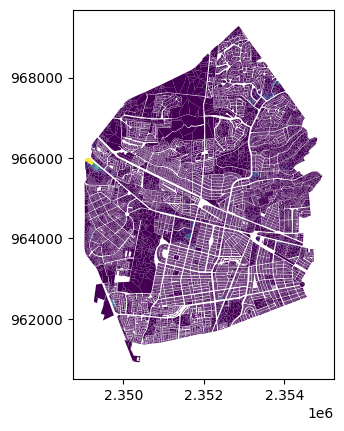

In [16]:
aop_kde.plot('servicios')

Merge data

In [17]:
aop_data = aop_data.merge(aop_kde[['fid','cultural_recreativo',
                                  'servicios','comercio','salud',
                                  'educacion','gobierno','industria']])
print(aop_data.shape)
aop_data.head(2)

(37061, 19)


,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,geometry,pobtot,cultural_recreativo,servicios,comercio,salud,educacion,gobierno,industria
0,0,Servicio,2257.817773,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,2747.599834,0.009869,0.063231,"MULTIPOLYGON (((2349620.239 965525.905, 234961...",0,0.0,3.647916,1.139708,0.0,0.0,0.0,0.138888
1,1,Sin dato,711.098560,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,900.765482,0.003235,0.090803,"MULTIPOLYGON (((2349506.214 965639.352, 234950...",0,0.0,34.112337,20.599681,0.0,0.0,0.0,3.432438


Calculate land use and population percentages

In [18]:
# divide total population by area
aop_area = aop_data[['CVEGEO','area_m2']].groupby('CVEGEO').sum().reset_index().rename(columns={'area_m2':'area_m2_tot'})
aop_data = aop_data.merge(aop_area, on='CVEGEO')
aop_data['pobtot_relative'] = aop_data['pobtot'] * (aop_data['area_m2']/aop_data['area_m2_tot'])
aop_data.head(2)

,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,...,pobtot,cultural_recreativo,servicios,comercio,salud,educacion,gobierno,industria,area_m2_tot,pobtot_relative
0,0,Servicio,2257.817773,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,2747.599834,0.009869,0.063231,...,0,0.0,3.647916,1.139708,0.0,0.0,0.0,0.138888,263158.125378,0.0
1,1,Sin dato,711.098560,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,900.765482,0.003235,0.090803,...,0,0.0,34.112337,20.599681,0.0,0.0,0.0,3.432438,263158.125378,0.0


In [19]:
aop_data = aop_data.rename(columns={'pobtot_relative':'habitacional',
                                   'educación':'educacion'})

In [20]:
uso_list = ['habitacional','cultural_recreativo','servicios',
           'comercio','salud','educacion','gobierno',
           'industria']

In [21]:
aop_data['uso_tot'] = aop_data[uso_list].sum(axis=1)

In [22]:
for us in uso_list:
    aop_data['pct_'+us] = aop_data[us]/aop_data['uso_tot']

In [23]:
aop_data = aop_data.fillna(0)
aop_data.head(2)

,fid,uso_suelo,area_m2,full_plus_code,CVEGEO,bld_area_m2,block_area_m2,pred_area_m2,pred_area_pct,bld_pred_area_pct,...,habitacional,uso_tot,pct_habitacional,pct_cultural_recreativo,pct_servicios,pct_comercio,pct_salud,pct_educacion,pct_gobierno,pct_industria
0,0,Servicio,2257.817773,75GRMHR2+458V,1412000011206018,173.7348,278416.454431,2747.599834,0.009869,0.063231,...,0.0,4.926511,0.0,0.0,0.740466,0.231342,0.0,0.0,0.0,0.028192
1,1,Sin dato,711.098560,75GRMGRX+GQP3,1412000011206018,81.7922,278416.454431,900.765482,0.003235,0.090803,...,0.0,58.144456,0.0,0.0,0.586683,0.354285,0.0,0.0,0.0,0.059033


Save data

In [24]:
aop_data.to_file('../../data/processed/prediccion_uso_suelo/test/area_of_prediction_kde.gpkg')